Apache Spark — фреймворк с открытым исходным кодом для реализации распределённой обработки неструктурированных и слабоструктурированных данных, входящий в экосистему проектов Hadoop. В отличие от классического обработчика из ядра Hadoop, реализующего двухуровневую концепцию MapReduce с хранением промежуточных данных на накопителях, Spark работает в парадигме резидентных вычислений — обрабатывает данные в оперативной памяти.

- http://jupyterhub.data.ae-rus.net/
- http://rm1z1.h.ae-rus.net:8088/cluster

In [1]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = (
        SparkSession
        .builder
        .config(
            conf=SparkConf()
            .setAppName('spark-test-app')
        ).getOrCreate()
)


In [2]:
spark.sql("show databases").show(10, False)

+----------+
|namespace |
+----------+
|aer_adm_sg|
|aer_ads_sg|
|aer_ba_sg |
|aer_bi_sg |
|aer_cdm_sg|
|aer_ds_sg |
|aer_dwh   |
|aer_dwh_sg|
|aer_meta  |
|aer_ods_sg|
+----------+
only showing top 10 rows



In [3]:
spark.stop()

# Spark setttings

In [4]:
!cat /opt/spark/conf/spark-defaults.conf

## managed by puppet

spark.master yarn
spark.eventLog.dir hdfs:///spark-history
spark.eventLog.enabled true
spark.eventLog.permissions 777
spark.io.compression.codec org.apache.spark.io.SnappyCompressionCodec
spark.executor.memory 2048m
spark.driver.memory 2048m
spark.serializer org.apache.spark.serializer.KryoSerializer
spark.yarn.queue ad-hoc
spark.port.maxRetries 200
spark.sql.warehouse.dir hdfs:///apps/hive/warehouse
spark.yarn.historyServer.address http://hadoop-ui2z1.h.ae-rus.net:18088
spark.history.ui.port 18088
spark.history.fs.cleaner.enabled true
spark.history.fs.cleaner.interval 1d
spark.history.fs.cleaner.maxAge 7d
spark.history.fs.logDirectory hdfs:///spark-history
spark.shuffle.service.enabled true
spark.shuffle.manager SORT
spark.shuffle.consolidateFiles true
spark.dynamicAllocation.enabled false
spark.yarn.am.memory 2048m
spark.yarn.am.cores 1
spark.driver.cores 1
spark.executor.cores 2
spark.yarn.am.memoryOverhead 1024m
spark.driver.memoryOverhead 1024m
spark.executor

- `spark.master`: `yarn`, variants: standalone, yarn, kubernetes. https://spark.apache.org/docs/latest/cluster-overview.html#cluster-manager-types
- `spark.deploy-mode`: `client`. In cluster mode, the Spark driver runs inside an application master process which is managed by YARN on the cluster, and the client can go away after initiating the application. In client mode, the driver runs in the client process, and the application master is only used for requesting resources from YARN. https://spark.apache.org/docs/latest/running-on-yarn.html
- `spark.yarn.queue`: The name of the YARN queue to which the application is submitted.
- `spark.driver.memory`: Amount of memory to use for the driver process, i.e. where SparkContext is initialized, in the same format as JVM memory strings with a size unit suffix ("k", "m", "g" or "t") (e.g. 512m, 2g). In client mode, this config must not be set through the SparkConf directly in your application, because the driver JVM has already started at that point. Instead, please set this through the --driver-memory command line option or in your default properties file. Be careful with values above "32g"! At least ~47 GB required to get the same storage
- `spark.executor.memory`: Amount of memory to use per executor process, in the same format as JVM memory strings with a size unit suffix ("k", "m", "g" or "t") (e.g. 512m, 2g).
- `spark.executor.memory_overhead`: Amount of non-heap memory to be allocated per driver process in cluster mode, in MiB unless otherwise specified. This is memory that accounts for things like VM overheads, interned strings, other native overheads, etc. This tends to grow with the container size (typically 6-10%). This option is currently supported on YARN, Mesos and Kubernetes. Note: Non-heap memory includes off-heap memory (when spark.memory.offHeap.enabled=true) and memory used by other driver processes (e.g. python process that goes with a PySpark driver) and memory used by other non-driver processes running in the same container. The maximum memory size of container to running driver is determined by the sum of spark.driver.memoryOverhead and spark.driver.memory.
- `spark.dynamicAllocation.enabled`: sometimes dynamic allocation causes instability. Needs `spark.shuffle.service.enabled` set to True
- `spark.driver.cores`: Number of cores to use for the driver process, only in cluster mode.
- `spark.executor.cores`: The number of cores to use on each executor
- `spark.sql.shuffle.partitions`: The default number of partitions to use when shuffling data for joins or aggregations.
- `spark.default.parallelism`: Default number of partitions in RDDs returned by transformations like join, reduceByKey, and parallelize when not set by user.
- `spark.stage.maxConsecutiveAttempts`: Number of consecutive stage attempts allowed before a stage is aborted.

Dynamic partitioning means the partitions are not configured before execution else it is made during run time depending on the size of file or partitions required. It ensures the best way of the utilization of RAM and the distribution of memory. Dynamic partitioning allows overwtiting only needed partitions instead of ALL TABLE
- `spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")`
- `hiveContext.setConf("hive.exec.dynamic.partition", "true")`
- `hiveContext.setConf("hive.exec.dynamic.partition.mode", "nonstrict")`

Broadcast tables
- `spark.sql.autoBroadcastJoinThreshold`: Configures the maximum size in bytes for a table that will be broadcast to all worker nodes when performing a join. By setting this value to -1 broadcasting can be disabled. May cause OOM

Dynamic allocation is pure evil! When you start loading data into memory it will load on fewer number of executors then it will further work. Thus not all executors will took part in all calculations. Data will be disbalanced between executors.

- `spark.dynamicAllocation.minExecutors`
- `spark.dynamicAllocation.maxExecutors`
- `spark.dynamicAllocation.initialExecutors`
- `spark.executor.instances`: for static allocation
- `spark.dynamicAllocation.executorIdleTimeout` set to 120s, if executor is idle for this time, it will be returned to pool
- `spark.dynamicAllocation.cachedExecutorIdleTimeout` set to 600s, if executir is idle but has cached information, discard it and return executor to pool


- `spark.port.maxRetries`: 200. Maximum number of retries when binding to a port before giving up. When a port is given a specific value (non 0), each subsequent retry will increment the port used in the previous attempt by 1 before retrying.
- `spark.serializer`: KryoSerializer instead of JavaSerializer; docs advise to use KryoSerializer when speed is required
- `spark.eventLog.enabled`: `true`. Whether to log Spark events, useful for reconstructing the Web UI after the application has finished.
- `spark.io.compression.codec`: Snappy or lz4 recommended
- `spark.yarn.am.memory`, `spark.yarn.am.cores`: ApplicationMaster settings
- `spark.sql.autoBroadcastJoinThreshold` sometimes throw OOM errors with no evident reason
- `spark.shuffle.reduceLocality.enabled = False` - equally repartition small dataframes between executors, currently maybe useless

https://spark.apache.org/docs/latest/running-on-yarn.html

https://spark.apache.org/docs/latest/configuration.html

https://spark.apache.org/docs/latest/monitoring.html

At this moment something went wrong... So, we'll distribute our own environment and try to use UDFs

# Distribute your environment on cluster nodes

1. Install your conda
2. `conda create -n pyspark_env python=3.8.5 numpy pandas scikit-learn scipy pyarrow conda-pack`
3. `conda pack -n pyspark_env -o pyspark_env.tar.gz`

In [1]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, types as t, Window as w

import re
import pandas as pd
import time
import uuid

import os
os.environ["PYSPARK_PYTHON"] = "pyspark_env/bin/python"

In [2]:
memory = '10g'
memory_overhead = '1g'
executor_memory = '5g'
cores = 3
num_executors = 5
app_name = "spark-test-app"
queue = 'ad-hoc'
dynamic_allocation = False
env_archive = "pyspark_env.tar.gz#pyspark_env"

def get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, 
    dynamic_allocation = False, parallelism=None, env_archive=None, broadcasting=True
):
    if not parallelism: 
        parallelism = cores * num_executors
    
    config = (
        SparkConf()
        .setMaster("yarn")
        .setAppName(app_name)
        .set("spark.yarn.queue", queue)
        .set('spark.network.timeout', "300s")
        .set('spark.executor.heartbeatInterval', "10s")
        .set('spark.driver.memory', memory)
        .set('spark.driver.memoryOverhead', memory_overhead)
        .set('spark.driver.maxResultSize', memory)
        .set('spark.executor.memory', executor_memory)
        .set('spark.executor.memoryOverhead', memory_overhead)
        .set('spark.sql.shuffle.partitions', parallelism)
        .set('spark.default.parallelism', parallelism)
        .set('spark.driver.cores', cores)
        .set('spark.executor.cores', cores)
        .set("spark.executor.instances", num_executors)
        .set("spark.stage.maxConsecutiveAttempts", 10)
        .set("spark.rpc.io.serverThreads", 64)
        .set('spark.sql.hive.convertMetastoreOrc', 'true')
        .set('spark.sql.orc.impl', 'native')
        .set('spark.sql.orc.enableVectorizedReader', 'true')
        .set("spark.sql.execution.arrow.enabled", "true")  # optimize spark -> pandas transfer
    )
    
    if dynamic_allocation is True:
        (
            config
            .set('spark.dynamicAllocation.enabled', True)
            .set("spark.shuffle.service.enabled", True)
            .set("spark.dynamicAllocation.minExecutors", min(1, num_executors // 10))
            .set("spark.dynamicAllocation.maxExecutors", num_executors)
        )
    if env_archive:
        config.set("spark.yarn.dist.archives", env_archive)
        
    if not broadcasting:
        (
            config
            .set("spark.sql.autoBroadcastJoinThreshold", -1)
            .set("spark.shuffle.reduceLocality.enabled", False)
        )
        
    spark = (
        SparkSession
        .builder
        .config(conf=config)
        .enableHiveSupport()
        .getOrCreate()
    )
    return spark


In [3]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive)

In [8]:
@f.udf(t.StringType())
def get_ds(partition):
    if partition is not None:
        partitions = partition.split('/')
        ds = [partition for partition in partitions if 'ds' in partition]
        if ds:
            return ds[0]
    return None

def max_pt(table):
    return spark.sql(f'show partitions {table}').select(f.max(get_ds('partition'))).collect()[0][0]

# Read table

In [12]:
start = time.time()
spark.sql("SELECT COUNT(1) FROM aer_dwh_sg.dim_aer_itm WHERE ds == (SELECT MAX(ds) FROM aer_dwh_sg.dim_aer_itm)").show()
print(time.time() - start)

+---------+
| count(1)|
+---------+
|169095056|
+---------+

227.9131565093994


In [16]:
start = time.time()
spark.sql("SELECT COUNT(1) FROM aer_dwh_sg.dim_aer_itm WHERE ds == 20220531").show()
print(time.time() - start)

+---------+
| count(1)|
+---------+
|169095056|
+---------+

3.9464569091796875


In [13]:
start = time.time()
print(spark.table("aer_dwh_sg.dim_aer_itm").where(max_pt("aer_dwh_sg.dim_aer_itm")).count())
print(time.time() - start)

169095056
3.9546356201171875


In [5]:
start = time.time()
df = spark.table("aer_dwh_sg.dim_aer_itm").where(max_pt("aer_dwh_sg.dim_aer_itm")).cache()
print(time.time() - start)

7.515697479248047


In [6]:
start = time.time()
print(df.count())
print(time.time() - start)

169505492
196.65721774101257


In [7]:
start = time.time()
print(df.count())
print(time.time() - start)

169505492
6.05268406867981


In [8]:
df.unpersist()

DataFrame[item_id: bigint, seller_admin_seq: bigint, seller_admin_id: string, seller_business_segment_cd: string, store_id: bigint, brand_id: bigint, brand_name: string, leaf_cate_id: bigint, top_cate_id: bigint, create_item_dttm: string, modify_item_time: string, item_type_cd: string, freight_template_id: bigint, package_type_cd: string, lot_cnt: bigint, package_length_meas: double, package_width_meas: double, package_height_meas: double, gross_weight_meas: double, item_locale_name: string, currency_cd: string, min_display_price_amt: bigint, max_display_price_amt: bigint, min_display_price_usd_amt: bigint, max_display_price_usd_amt: bigint, min_display_price_rub_amt: bigint, max_display_price_rub_amt: bigint, price_segment_cd: string, aeplus_item_flg: string, fmcg_item_flg: string, owh_item_flg: string, ship_to_russia_flg: string, ds: string]

Hive is working on top of Hadoop

In [ ]:
df = spark.sql("select * from table")
df.createOrReplaceTempView("tmp_table")  # spark.sql("SELECT * FROM tmp_table"), lifecycle is tied to sparksession lifetime

In [24]:
%%time
!hive -hiveconf hive.execution.engine=mr -e "SELECT COUNT(1) FROM aer_dwh_sg.dim_aer_itm WHERE ds == (SELECT MAX(ds) FROM aer_dwh_sg.dim_aer_itm);" 2> /dev/null

169095056
WARN: The method class org.apache.commons.logging.impl.SLF4JLogFactory#release() was invoked.
WARN: Please see http://www.slf4j.org/codes.html#release for an explanation.
CPU times: user 8.93 s, sys: 1.45 s, total: 10.4 s
Wall time: 13min 32s


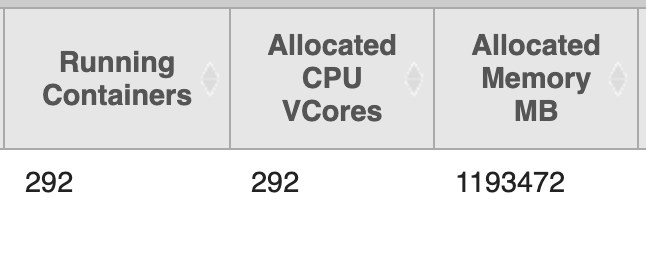

# Data types

In [7]:
ds = "20220316"
cate_df = spark.table("ke_common_test.cate_df").where(f.col("ds") == ds)
type(cate_df)

pyspark.sql.dataframe.DataFrame

In [8]:
cate_df = spark.sql("select * from ke_common_test.cate_df where ds == 20220316")
type(cate_df)

pyspark.sql.dataframe.DataFrame

# Save table

- mode: `append`,  `overwrite`, `ignore`, `error` or `errorifexists`
- format: `orc`, `parquet, ...

```df.write.format("parquet").mode("overwrite").partitionBy("partition_cols").insertInto("table_name")```

```df.write.mode("append").saveAsTable("table_name")```

```df.write.saveAsTable("table", mode="append")```

```df.write.format("parquet").save("df_name.parquet")```

```df.write.mode("overwrite").orc("df_name.orc")```

```df.write.mode("overwrite").insertInto("table_name", overwrite=True)  # dynamic partitioning```

# UDF introduction

In [9]:
df = pd.DataFrame(
    [
        [1, 'a', "ru : Продукты питания, pt : Alimentos, in : Makanan"], 
        [2, 'd', "en : Food, it : Cibo"], 
        [3, 'b', "fr : Alimentaire, ru : Продукты питания"], 
        [4, 'c', "es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos"], 
        [5, 'a', "pl : Żywności, nl : voedsel, tr : Gıda, pt : Alimentos"]
        ],
    columns=['a', 'b', 'c']
)
df

,a,b,c
0,1,a,"ru : Продукты питания, pt : Alimentos, in : Ma..."
1,2,d,"en : Food, it : Cibo"
2,3,b,"fr : Alimentaire, ru : Продукты питания"
3,4,c,"es : Alimentos, uk : Харчування, in : Makanan,..."
4,5,a,"pl : Żywności, nl : voedsel, tr : Gıda, pt : A..."


In [16]:
# spark doesn't check column names!
schema = t.StructType([
    t.StructField('a', t.IntegerType()),
    t.StructField('b', t.StringType()),
    t.StructField('c', t.StringType()),
])

# schema is optional, but now spark doesn't need to create subsample and check columns types
spark_df = spark.createDataFrame(df, schema=schema)

In [17]:
spark_df.show(3, truncate=False)

+---+---+---------------------------------------------------+
|a  |b  |c                                                  |
+---+---+---------------------------------------------------+
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan|
|2  |d  |en : Food, it : Cibo                               |
|3  |b  |fr : Alimentaire, ru : Продукты питания            |
+---+---+---------------------------------------------------+
only showing top 3 rows



## Simple UDF

In [18]:
test_udf = f.udf(lambda x: x**2 if x is not None else None, t.LongType())

In [19]:
spark_df.select("a", test_udf("a")).show(5, False)

+---+-----------+
|a  |<lambda>(a)|
+---+-----------+
|1  |1          |
|2  |4          |
|3  |9          |
|4  |16         |
|5  |25         |
+---+-----------+



## Multiple columns in UDF?

In [20]:
@f.udf(t.StructType([t.StructField("foo", t.LongType(), False), t.StructField("bar", t.LongType(), False)]))
def multiple_values_udf(x):
    return (x // 2, x % 2) if x else (float('nan'), float('nan'))

In [21]:
spark_df.select('a', multiple_values_udf('a').alias('baz')).show(5)
spark_df.select('a', multiple_values_udf('a').alias('baz')).printSchema()

+---+------+
|  a|   baz|
+---+------+
|  1|{0, 1}|
|  2|{1, 0}|
|  3|{1, 1}|
|  4|{2, 0}|
|  5|{2, 1}|
+---+------+

root
 |-- a: integer (nullable = true)
 |-- baz: struct (nullable = true)
 |    |-- foo: long (nullable = false)
 |    |-- bar: long (nullable = false)



In [23]:
spark_df.select('a', multiple_values_udf('a').alias('baz')).select("a", "baz.foo", 'baz.bar').show(5)

+---+---+---+
|  a|foo|bar|
+---+---+---+
|  1|  0|  1|
|  2|  1|  0|
|  3|  1|  1|
|  4|  2|  0|
|  5|  2|  1|
+---+---+---+



## Return dict

In [24]:
@f.udf(t.MapType(t.StringType(), t.StringType()))
def parse_feature(s):
    features = {}
    if isinstance(s, str):
        for subs in s.split(','):
            subs_split = subs.split(':')
            features[subs_split[0].lower().strip()] = subs_split[1].strip()
    return features


In [25]:
spark_df.select("c", parse_feature("c").alias("lang_dict")).show(3, False)

+---------------------------------------------------+--------------------------------------------------------+
|c                                                  |lang_dict                                               |
+---------------------------------------------------+--------------------------------------------------------+
|ru : Продукты питания, pt : Alimentos, in : Makanan|{ru -> Продукты питания, pt -> Alimentos, in -> Makanan}|
|en : Food, it : Cibo                               |{en -> Food, it -> Cibo}                                |
|fr : Alimentaire, ru : Продукты питания            |{fr -> Alimentaire, ru -> Продукты питания}             |
+---------------------------------------------------+--------------------------------------------------------+
only showing top 3 rows



In [26]:
new_df = (
    spark_df
    .select(
        "a", 
        "b", 
        "c", 
        f.explode(parse_feature("c")).alias("res_language", "category_desc"))
)

In [27]:
new_df.show(100, False)

+---+---+-------------------------------------------------------------+------------+----------------+
|a  |b  |c                                                            |res_language|category_desc   |
+---+---+-------------------------------------------------------------+------------+----------------+
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |ru          |Продукты питания|
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |pt          |Alimentos       |
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |in          |Makanan         |
|2  |d  |en : Food, it : Cibo                                         |en          |Food            |
|2  |d  |en : Food, it : Cibo                                         |it          |Cibo            |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |fr          |Alimentaire     |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |ru         

# Aggregation and window functions

In [28]:
(
    new_df
    .groupBy('res_language')  # may be multiple columns
    .agg(f.collect_list('a'), f.collect_set('category_desc'))
    .withColumnRenamed('res_language', 'language')
).show(100, False)

+--------+---------------+--------------------------+
|language|collect_list(a)|collect_set(category_desc)|
+--------+---------------+--------------------------+
|pt      |[4, 1, 5]      |[Alimentos]               |
|in      |[4, 1]         |[Makanan]                 |
|es      |[4]            |[Alimentos]               |
|uk      |[4]            |[Харчування]              |
|ru      |[1, 3]         |[Продукты питания]        |
|fr      |[3]            |[Alimentaire]             |
|it      |[2]            |[Cibo]                    |
|en      |[2]            |[Food]                    |
|tr      |[5]            |[Gıda]                    |
|nl      |[5]            |[voedsel]                 |
|pl      |[5]            |[Żywności]                |
+--------+---------------+--------------------------+



In [29]:
new_df_rn = (
    new_df
    .withColumn(
        'rn', f.row_number().over(
            w.partitionBy("res_language").orderBy(f.length('c').desc()))
    )
)
new_df_rn.show(100, False)

+---+---+-------------------------------------------------------------+------------+----------------+---+
|a  |b  |c                                                            |res_language|category_desc   |rn |
+---+---+-------------------------------------------------------------+------------+----------------+---+
|2  |d  |en : Food, it : Cibo                                         |en          |Food            |1  |
|4  |c  |es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos|es          |Alimentos       |1  |
|3  |b  |fr : Alimentaire, ru : Продукты питания                      |fr          |Alimentaire     |1  |
|4  |c  |es : Alimentos, uk : Харчування, in : Makanan, pt : Alimentos|in          |Makanan         |1  |
|1  |a  |ru : Продукты питания, pt : Alimentos, in : Makanan          |in          |Makanan         |2  |
|2  |d  |en : Food, it : Cibo                                         |it          |Cibo            |1  |
|5  |a  |pl : Żywności, nl : voedsel, tr : Gıd

# Pivot

In [82]:
data = [
    ("Banana", 1000, "USA"), ("Carrots", 1500, "USA"), ("Beans", 1600, "USA"),
    ("Orange", 2000, "USA"),("Orange", 2000, "USA"),("Banana", 400, "China"),
    ("Carrots", 1200, "China"),("Beans", 1500, "China"),("Orange", 4000, "China"),
    ("Banana", 2000, "Canada"),("Carrots", 2000, "Canada"),("Beans", 2000, "Mexico")
]
columns = ["Product","Amount","Country"]
df = spark.createDataFrame(data=data, schema=columns)
df.printSchema()
df.show(truncate=False)


root
 |-- Product: string (nullable = true)
 |-- Amount: long (nullable = true)
 |-- Country: string (nullable = true)

+-------+------+-------+
|Product|Amount|Country|
+-------+------+-------+
|Banana |1000  |USA    |
|Carrots|1500  |USA    |
|Beans  |1600  |USA    |
|Orange |2000  |USA    |
|Orange |2000  |USA    |
|Banana |400   |China  |
|Carrots|1200  |China  |
|Beans  |1500  |China  |
|Orange |4000  |China  |
|Banana |2000  |Canada |
|Carrots|2000  |Canada |
|Beans  |2000  |Mexico |
+-------+------+-------+



In [83]:
pivotDF = df.groupBy("Product").pivot("Country").sum("Amount")
pivotDF.printSchema()
pivotDF.show(truncate=False)

root
 |-- Product: string (nullable = true)
 |-- Canada: long (nullable = true)
 |-- China: long (nullable = true)
 |-- Mexico: long (nullable = true)
 |-- USA: long (nullable = true)

+-------+------+-----+------+----+
|Product|Canada|China|Mexico|USA |
+-------+------+-----+------+----+
|Orange |null  |4000 |null  |4000|
|Banana |2000  |400  |null  |1000|
|Carrots|2000  |1200 |null  |1500|
|Beans  |null  |1500 |2000  |1600|
+-------+------+-----+------+----+



In [84]:
pivotDF = (
    df
    .groupBy("Product","Country")
    .sum("Amount")
    .groupBy("Product")
    .pivot("Country")
    .sum("sum(Amount)")
)

pivotDF.show(truncate=False)

+-------+------+-----+------+----+
|Product|Canada|China|Mexico|USA |
+-------+------+-----+------+----+
|Orange |null  |4000 |null  |4000|
|Banana |2000  |400  |null  |1000|
|Carrots|2000  |1200 |null  |1500|
|Beans  |null  |1500 |2000  |1600|
+-------+------+-----+------+----+



# PandasUDF

Pandas UDFs are user defined functions that are executed by Spark using Arrow to transfer data and Pandas to work with the data, which allows vectorized operations. A Pandas UDF is defined using the pandas_udf as a decorator or to wrap the function, and no additional configuration is required. A Pandas UDF behaves as a regular PySpark function API in general.

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.pandas_udf.html

In [30]:
@f.pandas_udf("string")
def part_length(col):
    return pd.Series([str(uuid.uuid4())] * len(col))

@f.pandas_udf("long")
def add_one(col):
    return col + 1

In [31]:
(
    new_df_rn
    .repartition(5)
    .select('a', 'b', 'res_language', part_length('a').alias('part_id'))
    .withColumn('a+1', add_one('a'))
).show(100, False)

+---+---+------------+------------------------------------+---+
|a  |b  |res_language|part_id                             |a+1|
+---+---+------------+------------------------------------+---+
|3  |b  |ru          |49f29a18-85e3-472a-bc39-e240a51556ce|4  |
|5  |a  |pl          |49f29a18-85e3-472a-bc39-e240a51556ce|6  |
|4  |c  |es          |49f29a18-85e3-472a-bc39-e240a51556ce|5  |
|2  |d  |it          |5a56b390-6652-4a51-bc54-05c912c9f919|3  |
|1  |a  |ru          |5a56b390-6652-4a51-bc54-05c912c9f919|2  |
|5  |a  |pt          |5a56b390-6652-4a51-bc54-05c912c9f919|6  |
|4  |c  |pt          |5a56b390-6652-4a51-bc54-05c912c9f919|5  |
|1  |a  |in          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|2  |
|2  |d  |en          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|3  |
|4  |c  |in          |0c0e6397-b07f-43c5-9e75-83ef5ad1ff88|5  |
|4  |c  |uk          |c35f2940-96af-4d0b-a192-b841c28bb3f6|5  |
|5  |a  |nl          |c35f2940-96af-4d0b-a192-b841c28bb3f6|6  |
|1  |a  |pt          |c35f2940-96af-4d0b

In [32]:
@f.pandas_udf("col1 long, col2 string")
def stupidudf(col_a: pd.Series, col_b: pd.Series, col_rn: pd.Series) -> pd.DataFrame:
    # you can use here sklearn model
    result = pd.DataFrame(col_a + col_rn, columns=['col1'])
    result['col2'] = col_b + '_'
    return result

In [33]:
new_df_rn.select('a', 'b', 'rn', stupidudf('a', 'b', 'rn')).show(100)

+---+---+---+-------------------+
|  a|  b| rn|stupidudf(a, b, rn)|
+---+---+---+-------------------+
|  2|  d|  1|            {3, d_}|
|  4|  c|  1|            {5, c_}|
|  3|  b|  1|            {4, b_}|
|  4|  c|  1|            {5, c_}|
|  1|  a|  2|            {3, a_}|
|  2|  d|  1|            {3, d_}|
|  5|  a|  1|            {6, a_}|
|  5|  a|  1|            {6, a_}|
|  4|  c|  1|            {5, c_}|
|  5|  a|  2|            {7, a_}|
|  1|  a|  3|            {4, a_}|
|  1|  a|  1|            {2, a_}|
|  3|  b|  2|            {5, b_}|
|  5|  a|  1|            {6, a_}|
|  4|  c|  1|            {5, c_}|
+---+---+---+-------------------+



# PandasUDF + sklearn

In [157]:
import pandas as pd
import numpy as np
import pickle
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score

In [158]:
def get_dataset():
    iris_data = load_iris() 
    dataset = pd.DataFrame(np.hstack([iris_data.data, iris_data.target.reshape(-1, 1)]), 
                           columns=iris_data.feature_names + ['species'])
    dataset['species'] = dataset['species'].map(dict(enumerate(iris_data.target_names)))
    dataset['species'] = dataset['species'].map(str)
    return dataset

def get_features(dataset):
    features = dataset.copy()
    features['sepal_length_to_sepal_width'] = features['sepal length (cm)'] / features['sepal width (cm)']
    features['petal_length_to_petal_width'] = features['petal length (cm)'] / features['petal width (cm)']
    np.random.seed(42)
    features['is_train'] = np.random.binomial(1, 0.2, size=(len(features),))
    return features

In [159]:
features = get_features(get_dataset())

In [160]:
features.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,sepal_length_to_sepal_width,petal_length_to_petal_width,is_train
0,5.1,3.5,1.4,0.2,setosa,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,setosa,1.633333,7.0,1
2,4.7,3.2,1.3,0.2,setosa,1.468750,6.5,0


In [161]:
train = features[features['is_train'] == 1]
X_train = train.drop(columns=['is_train', 'species'])
y_train = train['species']

In [162]:
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)

In [163]:
logreg = LogisticRegression(penalty='l2', random_state=42, max_iter=500)
logreg.fit(X=X_train, y=y_train_enc)

LogisticRegression(max_iter=500, random_state=42)

In [164]:
with open('label_encoder.pickle', 'wb') as fd:
    pickle.dump(encoder, fd)

In [165]:
with open('logreg.pickle', 'wb') as fd:
    pickle.dump(logreg, fd)

In [166]:
test = features[features['is_train']== 0]
X_test = train.drop(columns=['is_train', 'species'])
y_test = train['species']

In [167]:
y_pred = logreg.predict(X_test)
y_pred = encoder.inverse_transform(y_pred)

In [168]:
precision_score(y_true=y_test, y_pred=y_pred, average="micro")

1.0

In [169]:
model_broadcasted = spark.sparkContext.broadcast(logreg)
encoder_broadcasted = spark.sparkContext.broadcast(encoder)

In [121]:
@f.pandas_udf("label string, part_id string")
def predict(sl: pd.Series, sw: pd.Series, pl: pd.Series, pw: pd.Series, sl2w: pd.Series, pl2w: pd.Series) -> pd.DataFrame:
    model = model_broadcasted.value
    enc = encoder_broadcasted.value
    df = pd.concat([sl, sw, pl, pw, sl2w, pl2w], axis=1)
    y_pred = model.predict(df)
    y_pred = enc.inverse_transform(y_pred)
    y_pred = pd.Series(y_pred)
    part_uuid = pd.Series([str(uuid.uuid4())] * len(sl))
    result = pd.concat([y_pred, part_uuid], axis=1)
    result.columns = ['label', 'part_id']
    return result

In [122]:
test_spark = spark.createDataFrame(features[features['is_train']== 0])

In [136]:
prediction = (
    test_spark
    .orderBy(f.rand())
    .repartition(test_spark.count() // 20)
    .select(
        predict('sepal length (cm)', 
                'sepal width (cm)', 
                'petal length (cm)', 
                'petal width (cm)',  
                'sepal_length_to_sepal_width', 
                'petal_length_to_petal_width').alias('prediction'), 
        'species')
    .select('prediction.label', 'species', 'prediction.part_id')
    .withColumn('rn', f.row_number().over(w.partitionBy('part_id').orderBy('part_id')))
).show(150)
        

+----------+----------+--------------------+---+
|     label|   species|             part_id| rn|
+----------+----------+--------------------+---+
|versicolor|versicolor|1fd4adf9-c524-43e...|  1|
|    setosa|    setosa|1fd4adf9-c524-43e...|  2|
|    setosa|    setosa|1fd4adf9-c524-43e...|  3|
| virginica| virginica|1fd4adf9-c524-43e...|  4|
|    setosa|    setosa|1fd4adf9-c524-43e...|  5|
|versicolor|versicolor|1fd4adf9-c524-43e...|  6|
| virginica| virginica|1fd4adf9-c524-43e...|  7|
| virginica| virginica|1fd4adf9-c524-43e...|  8|
|    setosa|    setosa|1fd4adf9-c524-43e...|  9|
|    setosa|    setosa|1fd4adf9-c524-43e...| 10|
| virginica|versicolor|1fd4adf9-c524-43e...| 11|
|    setosa|    setosa|1fd4adf9-c524-43e...| 12|
|versicolor|versicolor|1fd4adf9-c524-43e...| 13|
|    setosa|    setosa|1fd4adf9-c524-43e...| 14|
|versicolor|versicolor|1fd4adf9-c524-43e...| 15|
| virginica| virginica|1fd4adf9-c524-43e...| 16|
|versicolor|versicolor|1fd4adf9-c524-43e...| 17|
| virginica| virgini

In [34]:
spark.stop()

# Batch rename columns

А нет его

# Е%&@ие джойны

### да и вообще управление памятью

Тут должна была быть демонстрация, как за счет правильного партиционирования скорость джойна двух таблиц возрастает. Но похоже, что в версии 3.0 Spark был довольно сильно допилен в плане производительности. В общем, факир был пьян, и фокус не удался.

- `spark.sql.autoBroadcastJoinThreshold`: Configures the maximum size in bytes for a table that will be broadcast to all worker nodes when performing a join. By setting this value to -1 broadcasting can be disabled. May cause OOM

https://spark.apache.org/docs/latest/sql-performance-tuning.html

In [3]:
import time 

cores = 3
num_executors = 10
memory = '5g'
memory_overhead = '512m'
executor_memory = '1g'

spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False)

In [4]:
small_df = spark.table("ke_common_test.cate_extend_df").withColumnRenamed('category_lv5_id', 'leaf_cate_id')
print(small_df.cache().count())

204217


In [9]:
big_df = spark.table("aer_dwh_sg.dim_aer_itm").filter(max_pt("aer_dwh_sg.dim_aer_itm"))
print(big_df.cache().count())

170309119


- number of partitions and number of executors are different
- partitions distributed unevenly (ApplicationMaster -> Storage -> {table name} -> Data Distribution)

<img src="https://i.stack.imgur.com/pCYF1.png">

In [6]:
spark

In [10]:
start = time.time()

(
    big_df
    .orderBy(f.rand())
    .join(small_df, 
          on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

31.211281776428223


- uneven tasks distribution

In [29]:
spark.stop()

### repartition big df

In [30]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False)

In [31]:
small_df = spark.table("ke_common_test.cate_extend_df").withColumnRenamed('category_lv5_id', 'leaf_cate_id')
print(small_df.cache().count())

204217


In [32]:
big_df = spark.table("aer_dwh_sg.dim_aer_itm").filter(max_pt("aer_dwh_sg.dim_aer_itm")).repartition(num_executors * cores)
print(big_df.cache().count())

169095056


In [33]:
start = time.time()

(
    big_df
    .join(small_df, 
          on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

9.546894311904907


- tasks distribution a bit better

In [34]:
spark.stop()

### repartition both df

In [35]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False)

In [36]:
small_df = spark.table("ke_common_test.cate_extend_df").withColumnRenamed('category_lv5_id', 'leaf_cate_id').repartition(num_executors * cores)
print(small_df.cache().count())

204217


In [37]:
big_df = spark.table("aer_dwh_sg.dim_aer_itm").filter(max_pt("aer_dwh_sg.dim_aer_itm")).repartition(num_executors * cores)
print(big_df.cache().count())

169095056


In [38]:
start = time.time()

(
    big_df
    .join(small_df, 
          on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

10.770573854446411


- very good task distribution

In [39]:
spark.stop()

### repartition by joining column

In [40]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=False)

In [41]:
small_df = (
    spark.table("ke_common_test.cate_extend_df")
    .withColumnRenamed('category_lv5_id', 'leaf_cate_id')
    .repartition(num_executors * cores, 'leaf_cate_id')
)
print(small_df.cache().count())

204217


In [42]:
big_df = spark.table("aer_dwh_sg.dim_aer_itm").filter(max_pt("aer_dwh_sg.dim_aer_itm")).repartition(num_executors * cores, 'leaf_cate_id')
print(big_df.cache().count())

169095056


In [43]:
start = time.time()

(
    big_df
    .join(small_df, 
          on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

63.792555809020996


In [44]:
spark.stop()

### enable broadcasting

In [45]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive, broadcasting=True)

In [46]:
small_df = (
    spark.table("ke_common_test.cate_extend_df")
    .withColumnRenamed('category_lv5_id', 'leaf_cate_id')
    .repartition(num_executors * cores, 'leaf_cate_id')
)
print(small_df.cache().count())

204217


In [47]:
big_df = spark.table("aer_dwh_sg.dim_aer_itm").filter(max_pt("aer_dwh_sg.dim_aer_itm")).repartition(num_executors * cores, 'leaf_cate_id')
print(big_df.cache().count())

169095056


In [48]:
start = time.time()

(
    big_df
    .join(small_df, 
          on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

10.39299464225769


In [49]:
start = time.time()

(
    big_df.join(f.broadcast(small_df), on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

6.8964362144470215


In [50]:
start = time.time()

(
    big_df.join(small_df.hint("broadcast"), on='leaf_cate_id')
).count()

time_spent = time.time() - start
print(time_spent)

5.876885890960693


# Union, или как перестать страдать

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.unionByName.html

# Histograms

(array([1.69095052e+08, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([1.00020000e+04, 3.61608015e+17, 7.23216029e+17, 1.08482404e+18,
        1.44643206e+18, 1.80804007e+18, 2.16964809e+18, 2.53125610e+18,
        2.89286412e+18, 3.25447213e+18, 3.61608015e+18]),
 <BarContainer object of 10 artists>)

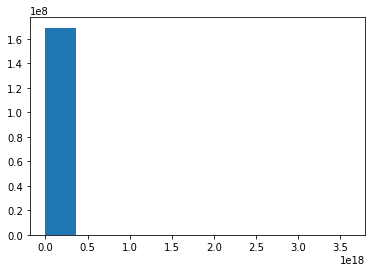

In [51]:
import matplotlib.pyplot as plt

bins, counts = big_df.select('item_id').rdd.flatMap(lambda x: x).histogram(10)
plt.hist(bins[:-1], bins=bins, weights=counts)

# Override Spark show method to pandas

In [52]:
# override show method to limit(n).toPandas()
from pyspark.sql.dataframe import DataFrame


def show(self, n=2):
    return self.limit(n).toPandas()


DataFrame.show = show

In [53]:
small_df.show(3)

,category_id,category_desc,category_level,is_leaf,category_lv1_id,category_lv1_desc,category_lv2_id,category_lv2_desc,category_lv3_id,category_lv3_desc,...,leaf_cate_id,category_lv5_desc,parent_category_id,parent_category_desc,category_path_ids,category_path_descs,category_path,category_group,category_type,res_language
0,403,Asciugamani,3,Y,15,Casa e giardino,405,Tessili per la casa,403,Asciugamani,...,403,Asciugamani,405,Tessili per la casa,"[15, 405, 403, 403, 403]","[Casa e giardino, Tessili per la casa, Asciuga...",Casa e giardino > Tessili per la casa > Asciug...,大美家,02,it
1,604,Lettori DVD e VCD,3,Y,44,Elettronica di consumo,100000308,Audio & Video per casa,604,Lettori DVD e VCD,...,604,Lettori DVD e VCD,100000308,Audio & Video per casa,"[44, 100000308, 604, 604, 604]","[Elettronica di consumo, Audio & Video per cas...",Elettronica di consumo > Audio & Video per cas...,大科技,02,it
2,629,Accessori e ricambi,2,N,44,Elettronica di consumo,629,Accessori e ricambi,629,Accessori e ricambi,...,629,Accessori e ricambi,44,Elettronica di consumo,"[44, 629, 629, 629, 629]","[Elettronica di consumo, Accessori e ricambi, ...",Elettronica di consumo > Accessori e ricambi,大科技,02,it


In [137]:
spark.stop()

# SparkML

In [138]:
import findspark

findspark.init()

import pandas as pd
import numpy as np
import pickle
from sklearn.datasets import load_iris

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [139]:
spark = get_context(
    app_name, queue, memory, executor_memory, memory_overhead, num_executors, cores, env_archive=env_archive)

In [140]:
def get_features(dataset):
    features = dataset.copy()
    features['sepal_length_to_sepal_width'] = features['sepal length (cm)'] / features['sepal width (cm)']
    features['petal_length_to_petal_width'] = features['petal length (cm)'] / features['petal width (cm)']
    np.random.seed(42)
    features['is_train'] = np.random.binomial(1, 0.8, size=(len(features),))
    return features

    
def get_dataset():
    iris_data = load_iris() 
    dataset = pd.DataFrame(np.hstack([iris_data.data, iris_data.target.reshape(-1, 1)]), columns=iris_data.feature_names + ['species'])
    dataset['species'] = dataset['species'].map(dict(enumerate(iris_data.target_names)))
    dataset['species'] = dataset['species'].map(str)
    return dataset

In [141]:
dataset = get_dataset()
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [142]:
features = get_features(dataset)
features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,sepal_length_to_sepal_width,petal_length_to_petal_width,is_train
0,5.1,3.5,1.4,0.2,setosa,1.457143,7.0,1
1,4.9,3.0,1.4,0.2,setosa,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,setosa,1.468750,6.5,1
3,4.6,3.1,1.5,0.2,setosa,1.483871,7.5,1
4,5.0,3.6,1.4,0.2,setosa,1.388889,7.0,1


In [143]:
spark

In [144]:
features_spark = spark.createDataFrame(features)
features_spark.show(3)

+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|sepal_length_to_sepal_width|petal_length_to_petal_width|is_train|
+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+
|              5.1|             3.5|              1.4|             0.2| setosa|          1.457142857142857|          6.999999999999999|       1|
|              4.9|             3.0|              1.4|             0.2| setosa|         1.6333333333333335|          6.999999999999999|       0|
|              4.7|             3.2|              1.3|             0.2| setosa|                    1.46875|                        6.5|       1|
+-----------------+----------------+-----------------+----------------+-------+---------------------------+-----------------------

In [145]:
inputCols = list(set(features.columns) - set(['is_train', 'species']))
vecAssembler = VectorAssembler(inputCols=inputCols, outputCol="features")

features_spark = vecAssembler.transform(features_spark)
features_spark.show(3)

+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+--------------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|sepal_length_to_sepal_width|petal_length_to_petal_width|is_train|            features|
+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+--------------------+
|              5.1|             3.5|              1.4|             0.2| setosa|          1.457142857142857|          6.999999999999999|       1|[0.2,6.9999999999...|
|              4.9|             3.0|              1.4|             0.2| setosa|         1.6333333333333335|          6.999999999999999|       0|[0.2,6.9999999999...|
|              4.7|             3.2|              1.3|             0.2| setosa|                    1.46875|                        6.5|       1|[0.2,6.5,4.7,1.3,...|
+---

In [146]:
func = f.udf(lambda x: 0 if x == 'virginica' else 1 if x == 'versicolor' else 2, t.IntegerType())
features_spark = features_spark.withColumn('label', func('species'))

features_spark.show(3)

+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+--------------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|sepal_length_to_sepal_width|petal_length_to_petal_width|is_train|            features|label|
+-----------------+----------------+-----------------+----------------+-------+---------------------------+---------------------------+--------+--------------------+-----+
|              5.1|             3.5|              1.4|             0.2| setosa|          1.457142857142857|          6.999999999999999|       1|[0.2,6.9999999999...|    2|
|              4.9|             3.0|              1.4|             0.2| setosa|         1.6333333333333335|          6.999999999999999|       0|[0.2,6.9999999999...|    2|
|              4.7|             3.2|              1.3|             0.2| setosa|                    1.46875|                        6.5|     

In [147]:
train = features_spark.filter(f.col('is_train') == 1)
test = features_spark.filter(f.col('is_train') == 0)

In [148]:
lr = LogisticRegression(maxIter=100, tol=1e-5, fitIntercept=True, featuresCol='features', labelCol='label')
lrModel = lr.fit(train)

In [149]:
predictions = lrModel.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

Test Accuracy = 0.9032258064516129


In [191]:
spark.stop()

# GPU

Oh shi~! We need one more environment here

```conda create -n gpu_env python=3.8.5 numpy pandas scikit-learn scipy pyarrow conda-pack pytorch torchvision```

Ho-ho-ho! This does not work. Install torchvision from pytorch channel

In [12]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, types as t

import torch
import torchvision
import numpy as np
import pandas as pd
import json
import pickle

import os

ENV_NAME = "gpu_env"
os.environ["PYSPARK_PYTHON"] = f"{ENV_NAME}/bin/python"

In [2]:
# Oops. This is still broken
# DE recommend use this code
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

_ = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/andrey.ruslantsev/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

In [3]:
_ = torchvision.models.resnet50(pretrained=False)

In [13]:
def get_model_for_eval():
    model = torchvision.models.resnet18(pretrained=False)
    model.load_state_dict(bc_model_state.value)
    model.eval()
    return model

In [14]:
memory = '10g'
memory_overhead = '1g'
executor_memory = '2g'
cores = 3
num_executors = 2
parallelism = cores * num_executors
env_archive = f"{ENV_NAME}.tar.gz#{ENV_NAME}"

spark = (
        SparkSession
        .builder
        .config(
            conf=SparkConf()
            .setMaster("yarn")
            .setAppName('gpu-test')
            .set("spark.yarn.queue", 'gpu')
            .set('spark.driver.memory', memory)
            .set('spark.driver.memoryOverhead', memory_overhead)
            .set('spark.driver.maxResultSize', memory)
            .set('spark.executor.memory', executor_memory)
            .set('spark.executor.memoryOverhead', memory_overhead)
            .set('spark.sql.shuffle.partitions', parallelism)
            .set('spark.default.parallelism', parallelism)
            .set('spark.driver.cores', cores)
            .set('spark.executor.cores', cores)
            .set("spark.executor.instances", num_executors)
            .set('spark.dynamicAllocation.enabled', False)
            .set("spark.dynamicAllocation.minExecutors", num_executors)
            .set("spark.dynamicAllocation.maxExecutors", num_executors)
            .set('spark.network.timeout', "300s")
            .set('spark.executor.heartbeatInterval', "10s")
            .set("spark.stage.maxConsecutiveAttempts", 10)
            .set("spark.rpc.io.serverThreads", 64)
            .set('spark.sql.hive.convertMetastoreOrc', 'true')
            .set('spark.sql.orc.impl', 'native')
            .set('spark.sql.orc.enableVectorizedReader', 'true')
            .set("spark.executor.resource.gpu.amount", "1")
            .set("spark.executor.resource.gpu.discoveryScript", "/opt/spark/examples/src/main/scripts/getGpusResources.sh")
            .set("spark.task.resource.gpu.amount", "1") 
            .set("spark.yarn.dist.archives", env_archive)
        ).enableHiveSupport().getOrCreate()
)

In [15]:
spark_df = spark.createDataFrame(pd.DataFrame(range(10_000), columns=['test']))
spark_df.show(3)

+----+
|test|
+----+
|   0|
|   1|
|   2|
+----+
only showing top 3 rows



In [16]:
model = torchvision.models.resnet18(pretrained=False)
model.eval()
print()

In [17]:
model_state = model.state_dict()
bc_model_state = spark.sparkContext.broadcast(model_state)

In [18]:
@f.pandas_udf("double")
def predict_batch_udf(data: pd.Series) -> pd.Series:
    import torch
    
    model = get_model_for_eval()
    device = torch.device('cuda')  # why it worked without imports? magic :) 
                                   # all existing objects are sended to executors during gettinh spark context
    model.to(device)
    model = torch.nn.DataParallel(model)
    test_data = torch.randn(len(data), 3, 224, 224) # random data...
    with torch.no_grad():
        prediction = (
            model(test_data.to(device))[:, 0]
            .detach()
            .cpu()
            .numpy()
            .reshape(-1, )
        )
        prediction = pd.Series(prediction)
    return prediction

In [19]:
spark_df = spark_df.repartition(1000).withColumn('prediction', predict_batch_udf(f.col('test')))
spark_df.show(3)

+----+------------------+
|test|        prediction|
+----+------------------+
| 691|0.9256718158721924|
|3712|1.0843791961669922|
|3088|0.9743777513504028|
+----+------------------+
only showing top 3 rows



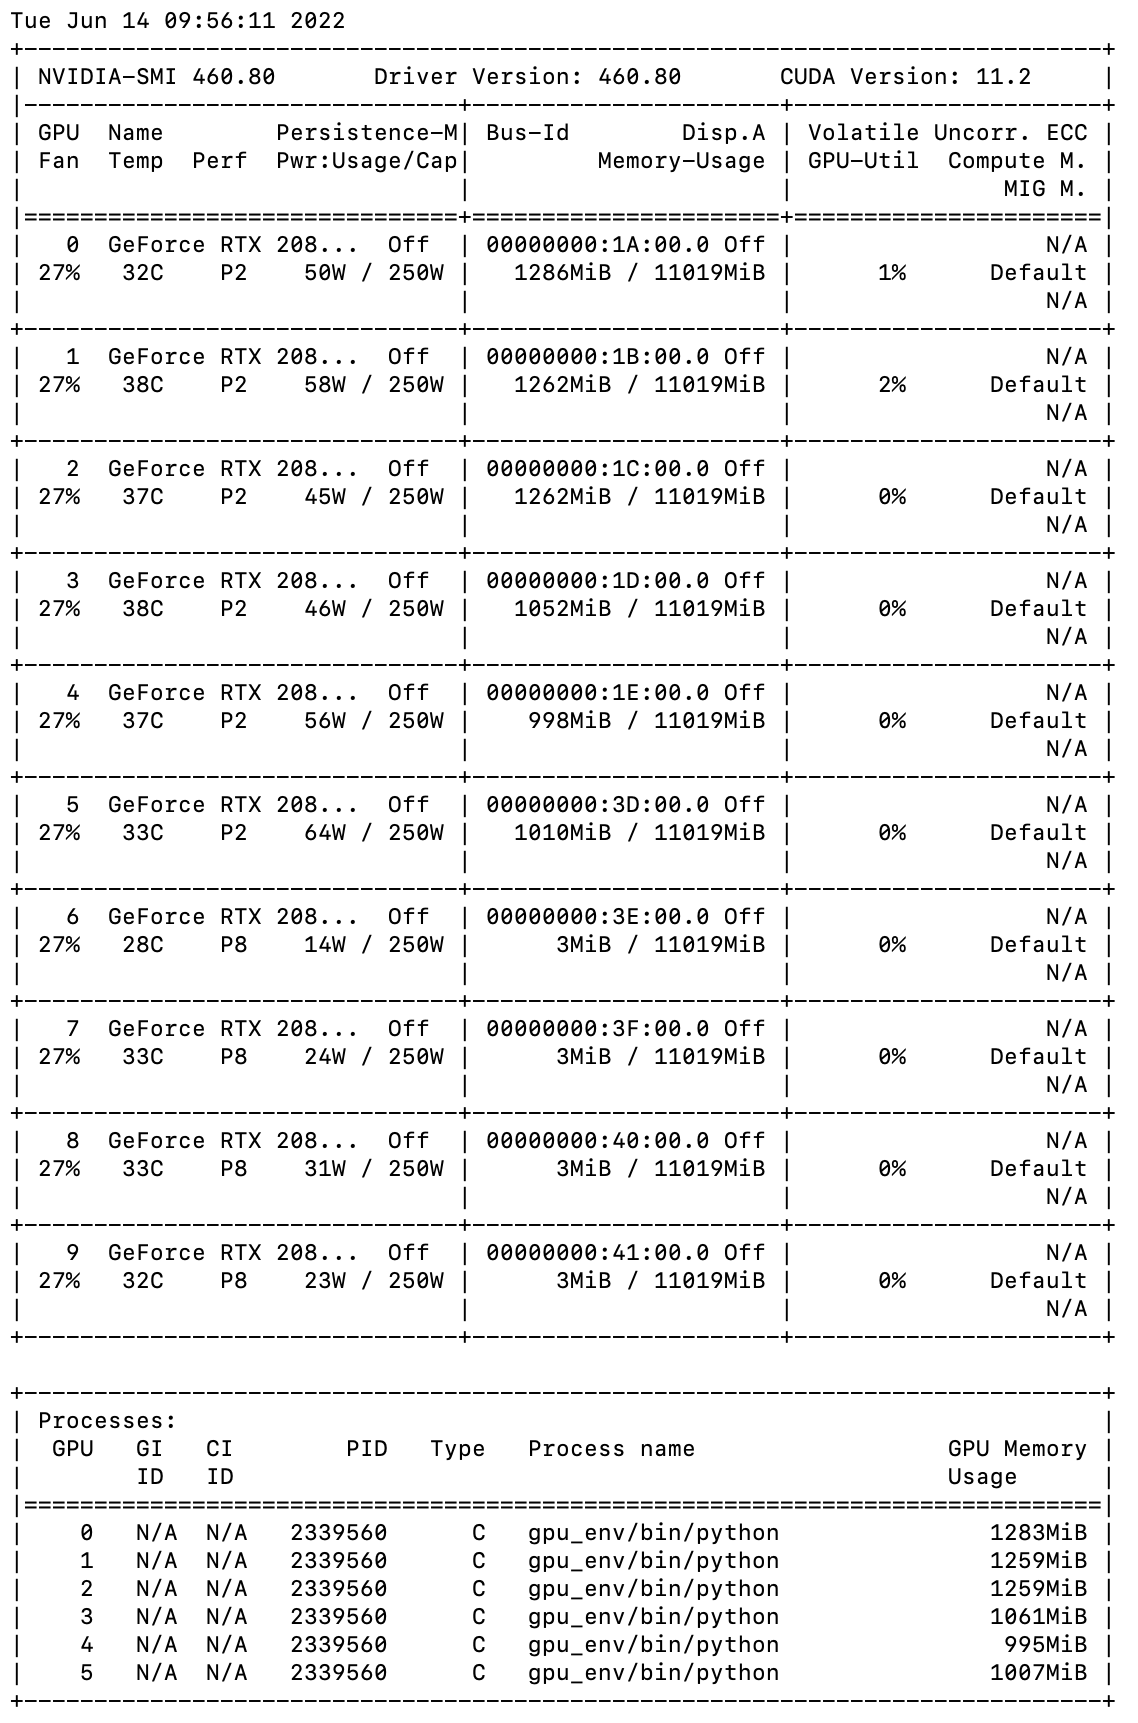

In [21]:
@f.pandas_udf("double")
def predict_batch_udf(data: pd.Series) -> pd.Series:
    import torch
    
    model = get_model_for_eval()
    device = torch.device('cuda:0') #  what if ...
    model.to(device)
    test_data = torch.randn(len(data), 3, 224, 224) # random data...
    with torch.no_grad():
        prediction = (
            model(test_data.to(device))[:, 0]
            .detach()
            .cpu()
            .numpy()
            .reshape(-1, )
        )
        prediction = pd.Series(prediction)
    return prediction

spark_df = spark_df.repartition(1000).withColumn('prediction', predict_batch_udf(f.col('test')))
spark_df.show(3)

+----+------------------+
|test|        prediction|
+----+------------------+
| 691|1.1294299364089966|
|3712|0.9135327339172363|
|3088|1.0853302478790283|
+----+------------------+
only showing top 3 rows



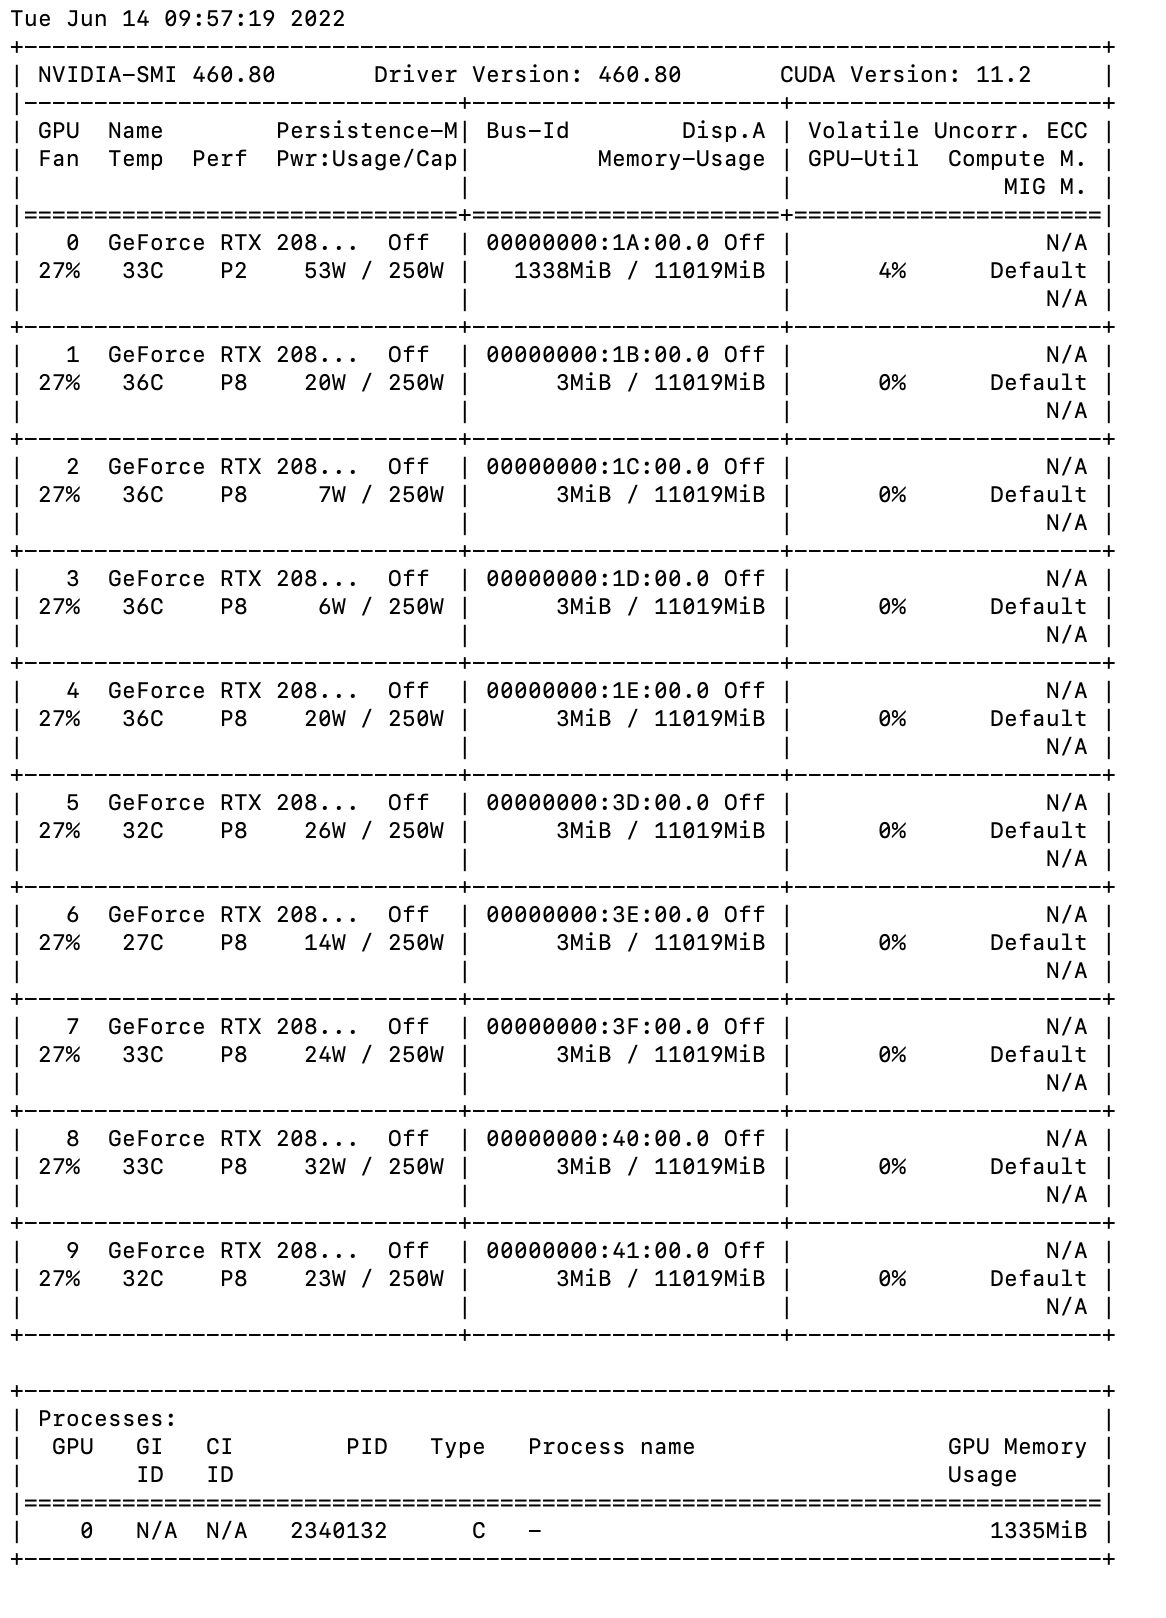

In [22]:
spark.stop()

# Example

In [192]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as f, types as t, Window as w
import re
import os

os.environ["PYSPARK_PYTHON"] = "pyspark_env/bin/python"

memory = '10g'
memory_overhead = '1g'
executor_memory = '5g'
cores = 3
num_executors = 5
parallelism = cores * num_executors

spark = (
        SparkSession
        .builder
        .config(
            conf=SparkConf()
            .setMaster("yarn")
            .setAppName('dim-aer-cate-extend-df')
            .set("spark.yarn.queue", 'ad-hoc')
            .set('spark.dynamicAllocation.enabled', True)
            .set("spark.shuffle.service.enabled", True)
            .set('spark.driver.memory', memory)
            .set('spark.driver.memoryOverhead', memory_overhead)
            .set('spark.driver.maxResultSize', memory)
            .set('spark.executor.memory', executor_memory)
            .set('spark.executor.memoryOverhead', memory_overhead)
            .set('spark.sql.shuffle.partitions', parallelism)
            .set('spark.default.parallelism', parallelism)
            .set('spark.driver.cores', cores)
            .set('spark.executor.cores', cores)
            .set("spark.executor.instances", num_executors)
            .set("spark.dynamicAllocation.minExecutors", min(1, num_executors // 10))
            .set("spark.dynamicAllocation.maxExecutors", num_executors)
            .set('spark.network.timeout', "300s")
            .set('spark.executor.heartbeatInterval', "10s")
            .set("spark.stage.maxConsecutiveAttempts", 10)
            .set("spark.rpc.io.serverThreads", 64)
            .set('spark.sql.hive.convertMetastoreOrc', 'true')
            .set('spark.sql.orc.impl', 'native')
            .set('spark.sql.orc.enableVectorizedReader', 'true')
            .set("spark.yarn.dist.archives", "pyspark_env.tar.gz#pyspark_env")
        ).enableHiveSupport().getOrCreate()
)


In [193]:
@f.udf(t.MapType(t.StringType(), t.StringType()))
def parse_feature(s):
    features = {}
    if isinstance(s, str):
        for subs in re.split(r";(?=\w{2,5}:)", s):
            subs_split = subs.split(':', 1)
            features[subs_split[0].lower()] = subs_split[1]  # if len(subs_split) > 1 else 'unknown'
    return features


@f.udf(t.StringType())
def concat_slice(arr, sep, start=0, num=None):
    if not arr:
        return ""
    if num == None:
        num = len(arr)
    return sep.join(arr[start: start + num])


In [194]:
def main(cate_df):
    source_descriptions = (
        cate_df.select(
            "category_id", 
            f.lit("en").alias("res_language"), 
            "category_desc"
        )
        .union(
            cate_df.select("category_id", f.explode(parse_feature("lang_feature")).alias("res_language", "category_desc"))
        )
    )
    
    source_descriptions = (
        source_descriptions
        .select("category_id", f.regexp_replace(f.col("res_language"), "\n", "").alias("res_language"), "category_desc")
        .withColumn('rn', f.row_number().over(
            w.partitionBy(["category_id", "res_language"]).orderBy(f.length('category_desc').desc())
        ))
        .where(f.col('rn') <= 1)
        .drop('rn')
    )
    
    category_descriptions = (
        source_descriptions.select('category_id').distinct()
        .crossJoin(source_descriptions.select('res_language').distinct())
        .join(source_descriptions, on=['res_language', 'category_id'], how="left")
        .select('res_language', 'category_id', f.coalesce(f.col('category_desc'), f.lit("")).alias('category_desc'))
    ).cache()
    
    cate_extend_df = (
        cate_df
        .select("category_id", "category_level", "is_leaf", 
                "category_lv1_id", "category_lv2_id", "category_lv3_id", "category_lv4_id", "category_lv5_id", 
                "parent_category_id", "category_group", "category_type")
        .join(category_descriptions, on="category_id")
        .join(
            category_descriptions.select(
                f.col("category_id").alias("parent_category_id"), 
                "res_language", 
                f.col("category_desc").alias("parent_category_desc")
            ), 
            how="left", on=["parent_category_id", "res_language"])
        .withColumn("parent_category_desc", f.coalesce("parent_category_desc", f.lit("")))
    )

    for i in range(1, 6):
        cate_extend_df = (
            cate_extend_df
            .join(
                category_descriptions.select(
                    f.col("category_id").alias(f"category_lv{i}_id"), 
                    "res_language", 
                    f.col("category_desc").alias(f"category_lv{i}_desc")), 
                how="left", on=[f"category_lv{i}_id", "res_language"])
            .withColumn(f"category_lv{i}_desc", f.coalesce(f"category_lv{i}_desc", f.lit("")))
        )

    cate_extend_df = (
        cate_extend_df
        .select(
            "category_id",
            "category_desc",
            "category_level",
            "is_leaf",
            "category_lv1_id",
            "category_lv1_desc",
            "category_lv2_id",
            "category_lv2_desc",
            "category_lv3_id",
            "category_lv3_desc",
            "category_lv4_id",
            "category_lv4_desc",
            "category_lv5_id",
            "category_lv5_desc",
            "parent_category_id",
            "parent_category_desc",
            f.array(
                "category_lv1_id",
                "category_lv2_id",
                "category_lv3_id",
                "category_lv4_id",
                "category_lv5_id",
            ).alias("category_path_ids"),
            f.array(
                "category_lv1_desc",
                "category_lv2_desc",
                "category_lv3_desc",
                "category_lv4_desc",
                "category_lv5_desc",
            ).alias("category_path_descs"),
            concat_slice(f.array(
                "category_lv1_desc",
                "category_lv2_desc",
                "category_lv3_desc",
                "category_lv4_desc",
                "category_lv5_desc",
            ), f.lit(" > "), f.lit(0), "category_level").alias("category_path"),
            "category_group",
            "category_type",
            "res_language",
        )
    )
    
    return cate_extend_df

In [195]:
ds = "20220316"
cate_df = spark.table("ke_common_test.cate_df").where(f.col("ds") == ds)
cate_extend_df = main(cate_df)

cate_extend_df.orderBy(f.rand()).show(3)

+-----------+----------------+--------------+-------+---------------+--------------------+---------------+--------------------+---------------+--------------------+---------------+-----------------+---------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+------------+
|category_id|   category_desc|category_level|is_leaf|category_lv1_id|   category_lv1_desc|category_lv2_id|   category_lv2_desc|category_lv3_id|   category_lv3_desc|category_lv4_id|category_lv4_desc|category_lv5_id|category_lv5_desc|parent_category_id|parent_category_desc|   category_path_ids| category_path_descs|       category_path|category_group|category_type|res_language|
+-----------+----------------+--------------+-------+---------------+--------------------+---------------+--------------------+---------------+--------------------+---------------+-----------------+---------------+-----------------+------------

In [197]:
cate_extend_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category_id#1629L, category_desc#1804, category_level#1631L, is_leaf#1632, category_lv1_id#1633L, category_lv1_desc#2175, category_lv2_id#1635L, category_lv2_desc#2334, category_lv3_id#1637L, category_lv3_desc#2495, category_lv4_id#1639L, category_lv4_desc#2658, category_lv5_id#1641L, coalesce(category_lv5_desc#2678, ) AS category_lv5_desc#2823, parent_category_id#1643L, parent_category_desc#2018, array(category_lv1_id#1633L, category_lv2_id#1635L, category_lv3_id#1637L, category_lv4_id#1639L, category_lv5_id#1641L) AS category_path_ids#2843, array(category_lv1_desc#2175, category_lv2_desc#2334, category_lv3_desc#2495, category_lv4_desc#2658, coalesce(category_lv5_desc#2678, )) AS category_path_descs#2844, pythonUDF0#3695 AS category_path#2846, category_group#1645, category_type#1648, res_language#1702]
   +- BatchEvalPython [concat_slice(array(category_lv1_desc#2175, category_lv2_desc#2334, category_lv3_desc#2495, cat